In [1]:
# adapted from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

%matplotlib inline
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [0]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist = np.load('data/mnist.npz')
(x_train, y_train), (x_test, y_test) = (mnist['x_train'], mnist['y_train']), (mnist['x_test'], mnist['y_test'])

In [0]:
J = 2    # dimension of the latent space
D = 784    # dim of input space

# pre-processing
x_train = np.reshape(x_train, [-1, D])
x_test = np.reshape(x_test, [-1, D])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Let the prior over latent variables p(z) be J-dimensional standard Gaussian distribution; let the probabilistic
# decoder p_theta(x|z) be D-dimensional multivariate Bernoulli with independent dimensions (equation 11 in Appendix
# C.1); let the encoder q_phi(z|x) be J-dimensional Gaussian with diagonal covariance (equation 12 in Appendix C.1)
# so that the KL divergence term in ELBO is given in closed-form (Appendix B)

In [4]:
# encoder model; map x to the parameters (phi_mu, phi_logvar) of the approximate posterior q_phi(z|x), as well as a
# sample z from q_phi(z|x); we only use a single sample (L=1) as in the paper for the MCMC approximation (sec 2.3)
x_input = Input((D,), name='x')    # tensor shape (?, 786), where ? is the size of minibatch
z_h_dim = 500    # size of the first hidden layer of the encoder network
z_h = Dense(z_h_dim, activation='tanh')(x_input)    # just like eq (12), C.2
phi_mu = Dense(J, name='phi_mu')(z_h)
phi_logvar = Dense(J, name='phi_logvar')(z_h)

def sample_z(args):
    # use reparameterization trick to obtain a sample from q_phi(z|x^i), for every example x^i in the minibatch
    # outputs z with shape (?, z_dim), where ? stands for minibatch size
    phi_mu, phi_logvar = args
    phi_var = K.exp(phi_logvar)
    phi_sig = phi_var ** 0.5
    epsilon = K.random_normal(shape=K.shape(phi_sig))    # K.shape: https://github.com/keras-team/keras/issues/5211
    z = phi_mu + phi_sig * epsilon
    return z  # (?, J)
z = Lambda(sample_z, output_shape=(J,), name='sample_z')([phi_mu, phi_logvar])    # have to wrap this tensor in a layer for Model
# call to work; see https://github.com/keras-team/keras/issues/6263   the function being wrapped must take 1 arg
encoder = Model(inputs=x_input, outputs=z, name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          392500      x[0][0]                          
__________________________________________________________________________________________________
phi_mu (Dense)                  (None, 2)            1002        dense_1[0][0]                    
__________________________________________________________________________________________________
phi_logvar (Dense)              (None, 2)            1002        dense_1[0][0]                    
__________________________________________________________________________________________________
sample_z (

In [5]:
# decoder model; map z to the parameters theta_mu of the likelihood p_theta(x|z), in this case a multi-variate
# Bernoulli
z_input = Input((J,), name='z')
x_h_dim = 500   # size of the first hidden layer of the decoder network
x_h = Dense(x_h_dim, activation='tanh')(z_input)    # eq (11), C.1
y = Dense(D, activation='sigmoid', name='x_logits')(x_h)    # eq (11), C.1; logits for image pixels being on/off, (?, 784)
decoder = Model(inputs=z_input, outputs=y, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1500      
_________________________________________________________________
x_logits (Dense)             (None, 784)               392784    
Total params: 394,284
Trainable params: 394,284
Non-trainable params: 0
_________________________________________________________________


In [6]:
# build VAE as one Keras model
# x_output = decoder(encoder(x_input))    # outputs are logits
x_output = decoder(encoder(x_input))    # outputs are logits
vae = Model(inputs=x_input, outputs=x_output)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 394504    
_________________________________________________________________
decoder (Model)              (None, 784)               394284    
Total params: 788,788
Trainable params: 788,788
Non-trainable params: 0
_________________________________________________________________


In [0]:
# loss
xent_loss = D * binary_crossentropy(x_input, x_output)    # vector of shape (?); rescale by D, because 
# 'binary_crossentropy' calculates the mean across the pixels, but we want the sum
kl_loss = -0.5 * K.sum(1 + phi_logvar - phi_mu **2 - K.exp(phi_logvar), axis=-1)    # vector of shape (?); we're
# minimizing -ELBO, hence negated
loss = K.mean(xent_loss + kl_loss)    # make it batch size independent

In [8]:
vae.add_loss(loss)
vae.compile(loss=None, optimizer='adadelta')    # if we want to use the loss kwarg in model.compile, 'loss' would
# need to be written as a function that takes (x_input, x_output) as arg, instead of a custom op

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


In [9]:
epochs = 40
batch_size = 100
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 7s 119us/step - loss: 200.7443 - val_loss: 183.9392
Epoch 2/40
60000/60000 [==============================] - 6s 102us/step - loss: 181.1966 - val_loss: 178.0154
Epoch 3/40
60000/60000 [==============================] - 6s 102us/step - loss: 177.0143 - val_loss: 175.3122
Epoch 4/40
24300/60000 [===========>..................] - ETA: 3s - loss: 174.197960000/60000 [==============================] - 6s 102us/step - loss: 173.1681 - val_loss: 170.7559
Epoch 5/40
60000/60000 [==============================] - 6s 102us/step - loss: 169.7557 - val_loss: 168.5747
Epoch 6/40
60000/60000 [==============================] - 6s 102us/step - loss: 167.4907 - val_loss: 165.6503
Epoch 7/40
60000/60000 [==============================] - 6s 101us/step - loss: 165.8160 - val_loss: 165.5939
Epoch 8/40
60000/60000 [==============================] - 6s 102us/step - loss: 164.5859 - val_loss: 165.5661

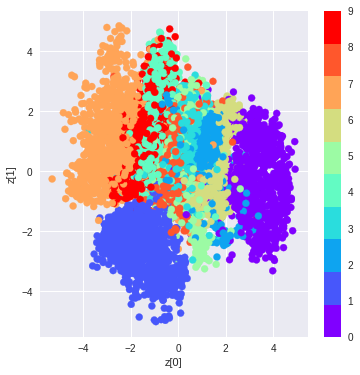

In [10]:
# visualize the posterior distributions q_phi(z|x) on test samples
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
# cmap = plt.cm.rainbow
cmap = plt.cm.get_cmap('rainbow', 10) # use discrete colors; https://stackoverflow.com/questions/14777066
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=cmap)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()

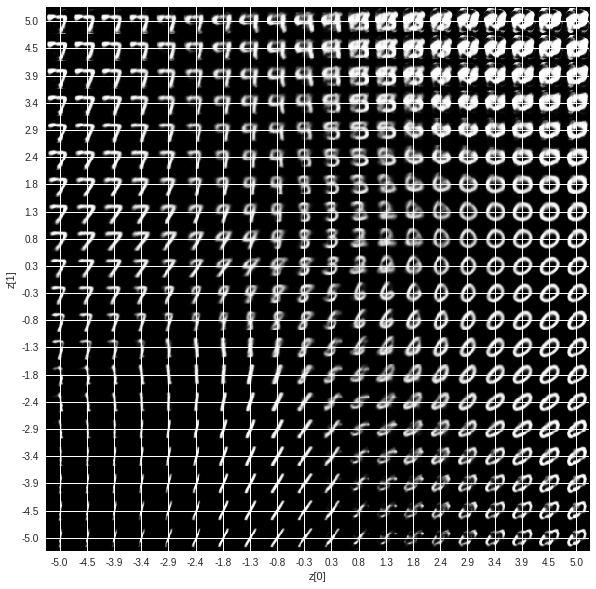

In [11]:
# visualize the decoder distributions p_theta(x|z) for points on a grid in the
# latent space

# display a nxn 2D manifold of digits
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
lims = [-5, 5]
grid_x = np.linspace(*lims, n)
grid_y = np.linspace(*lims, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()